In [27]:
import numpy as np
import scipy.stats
import random
from typing import Callable, Union, Dict, Any
from matplotlib import pyplot as plt
from matplotlib import patches as ptc
import pickle

In [28]:
import typing

# Experimental

In [29]:
np.random.choice([0, 1, 2, 3], 2, replace=False)

array([3, 0])

In [30]:
def keep_bounds(population, bounds):
    return np.clip(population, bounds[:, 0], bounds[:, 1])

def __parents_choice(population, n_parents, n_rows):
    pob_size = population.shape[0]
    choices = np.indices((pob_size, pob_size))[1]
    mask = np.ones(choices.shape, dtype=bool)
    np.fill_diagonal(mask, 0)
    choices = choices[mask].reshape(pob_size, pob_size - 1)
    parents = np.array([np.random.choice(row, n_parents, replace=False) for row in choices[:n_rows]])

    return parents

def apply_mutation(population, archive, population_fitness, f, p, bounds):
  # If there's not enough population we return it without mutating
  if len(population) < 4:
      return population

  # 1. We find the best parent
  p_best = []
  for p_i in p:
      best_index = np.argsort(population_fitness)[:max(2, int(round(p_i*len(population))))]
      p_best.append(np.random.choice(best_index))

  if archive:
    union = np.concatenate((population, archive), axis=0)
  else:
    union = population

  p_best = np.array(p_best)
  # 2. We choose two random parents
  parents = __parents_choice(union, 2, population.shape[0])
  mutated = population + f * (population[p_best] - population)
  mutated += f * (union[parents[:, 0]] - union[parents[:, 1]])

  return keep_bounds(mutated, bounds)


def apply_crossover(population, mutated, cr):
  chosen = np.random.rand(*population.shape)
  j_rand = np.random.randint(0, population.shape[1])
  chosen[j_rand::population.shape[1]] = 0
  return np.where(chosen <= cr, mutated, population)

def init_population(population_size, individual_size, bounds):
  population = np.random.randn(population_size, individual_size)
  return keep_bounds(population, bounds)

In [32]:
def select(population, new_population, fitness, new_fitness, return_indexes=False):
  indexes = np.where(fitness > new_fitness)[0]
  population[indexes] = new_population[indexes]
  if return_indexes:
      return population, indexes
  else:
      return population

In [31]:
  def apply_fitness(self, population, useless_penalty, activated_penalty):
    normalized_population = np.around(population).astype(np.int32)
    normalized_population[normalized_population == -1] = 0
    normalized_population = np.abs(normalized_population)
    residual = np.abs(population - normalized_population)

    f = np.zeros((population.shape[0], self.m), dtype=np.int32)
    useless = np.zeros((population.shape[0], ), dtype=np.int32)
    activated = np.zeros((population.shape[0], ), dtype=np.int32)

    for i, individual in enumerate(normalized_population):
      pan, freq = np.unique(individual, return_counts=True)
      activated[i] = self.n
      if pan[-1] == 8:
        activated[i] -= freq[-1]

      indexes = individual != 8
      Ts = self.T[indexes, :, individual[indexes]]
      useless_sensors = np.sum(Ts, axis=1)
      useless[i] = np.sum(useless_sensors == 0)
      f[i] = np.sum(Ts, axis=0)
    f = np.minimum(f, self.K)
    priority_factors = np.sqrt(self.K)
    return np.sum(priority_factors*np.square(f - self.K), axis=1) + useless_penalty*useless + activated_penalty*(activated-useless)

# Load data

In [33]:
!gdown 1jF6VzCJsvVRwiuh1yMYCDxAQGtFISrcm
!gdown 1kXT0P1_qKC2VNRf-QLF0lh0AGtT0otzE

Downloading...
From: https://drive.google.com/uc?id=1jF6VzCJsvVRwiuh1yMYCDxAQGtFISrcm
To: /content/fix_targets.pkl
100% 4.21M/4.21M [00:00<00:00, 95.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kXT0P1_qKC2VNRf-QLF0lh0AGtT0otzE
To: /content/fix_sensors.pkl
100% 4.45M/4.45M [00:00<00:00, 148MB/s]


In [34]:
with open("/content/fix_sensors.pkl", 'rb') as f:
  fs_data = pickle.load(f)

with open("/content/fix_targets.pkl", 'rb') as f:
  ft_data = pickle.load(f)


In [35]:
sample = fs_data[0]['small'][-2]

# Plot

In [36]:
def make_pan_boundaries(centroid, q, radius):
    # first line always lies on x_axis
    ans = []
    theta = 2*np.pi/q
    for i in range(q):
        x = radius*np.cos(theta*i)
        y = radius*np.sin(theta*i)
        ans.append((centroid[0] + x, centroid[1] + y))

    return ans

In [37]:
10 + 0.1*np.array(sample['K'])

array([10.2, 10.2, 10.2, 10.2, 10.1, 10.2, 10.1, 10.1, 10.2, 10.2, 10.1,
       10.2, 10.2, 10.2, 10.3, 10.1, 10.3, 10.2, 10.3, 10.2, 10.3, 10.2,
       10.3, 10.3, 10.3, 10.1, 10.3, 10.1, 10.2, 10.3, 10.2, 10.2, 10.3,
       10.1, 10.3, 10.2, 10.2, 10.3, 10.1, 10.1, 10.2, 10.2, 10.1, 10.3,
       10.2, 10.1, 10.2, 10.3, 10.1, 10.2, 10.3, 10.2, 10.3, 10.3, 10.1,
       10.3, 10.2, 10.3, 10.3, 10.1, 10.3, 10.3, 10.2, 10.1, 10.1, 10.1,
       10.3, 10.1, 10.3, 10.3, 10.2, 10.2, 10.2, 10.2, 10.2, 10.3, 10.3,
       10.1, 10.3, 10.3, 10.2, 10.3, 10.2, 10.1, 10.1, 10.3, 10.1, 10.3,
       10.1, 10.2, 10.2, 10.2, 10.2, 10.3, 10.1, 10.3, 10.2, 10.3, 10.1,
       10.3, 10.1, 10.3, 10.1, 10.1, 10.2, 10.1, 10.2, 10.2, 10.2, 10.3,
       10.3, 10.3, 10.3, 10.1, 10.1, 10.3, 10.1, 10.1, 10.2])

In [38]:
def show_network(network, direction=None, activate=None, figsize=None):
    n = network['n']
    m = network['m']
    q = network['q']
    k = np.array(network['K'])
    margin = network['margin']
    targets = network['targets']
    sensors = network['sensors']
    radius = network['radius']
    tar_size = 20.0 + 10.0*k

    if figsize is not None:
      plt.figure(figsize=(figsize, figsize))

    activate_alpha = 0.5 + 0.5*activate.astype(float)

    tar_x = [i[0] for i in targets]
    tar_y = [i[1] for i in targets]
    plt.scatter(tar_x, tar_y, marker='^', s=tar_size, c='r', label='targets')
    sen_x = [i[0] for i in sensors]
    sen_y = [i[1] for i in sensors]
    plt.scatter(sen_x, sen_y, marker='o', s=30, c='g', alpha=activate_alpha, label='sensors')
    ax = plt.gca()

    for i in range(len(sensors)):
      if activate[i]:
        sensor = sensors[i]
        active = True

        if sensors_mask is not None:
            active = False
            if sensors_mask[i] != q:
                theta = 360.0/q
                dir = sensors_mask[i]
                active = True
                theta1, theta2 = theta*dir, theta*(dir+1)
                wedge = ptc.Wedge(sensors[i], radius, theta1, theta2, color='#34e1eb', alpha=0.4)
                ax.add_artist(wedge)
        if active:
            circle = plt.Circle(sensor, radius, color='m', fill=False, linewidth=0.4)
            ax.add_artist(circle)
            pan_boundaries = make_pan_boundaries(sensor, q, radius)
            for point in pan_boundaries:
                plt.plot([sensor[0], point[0]], [sensor[1], point[1]], 'b--', alpha=0.2)

    plt.xlim(margin[0])
    plt.ylim(margin[1])
    ax.set_aspect(1.0)  # make aspect ratio square

    plt.legend()

    plt.show()

In [13]:
show_network(sample, figsize=10)

AttributeError: ignored

<Figure size 1000x1000 with 0 Axes>

# Linear Population Size Reduction of Success-History Based Parameter Adaptation for Differential Evolution



[link](https://sci-hub.se/10.1109/CEC.2014.6900380)

In [39]:
def is_within_FoV(bisector, target, sensor, radius):
    target = np.asarray(target)
    sensor = np.asarray(sensor)
    bisector = np.asarray(bisector)
    v = target - sensor
    dist = np.linalg.norm(v)
    scalar = bisector.dot(v)
    return scalar + 1e-7 >= radius*dist*np.cos(np.pi/8) and dist - 1e-7 <= radius

def init_T(network):
    sensors = network['sensors']
    targets = network['targets']
    radius = network['radius']
    n = network['n']
    m = network['m']
    q = network['q']
    T = np.zeros((n, m, q), dtype=bool)

    bisectors = []
    for i in range(q):
        bisectors.append((radius*np.cos(np.pi*(1 + i*2)/q), radius*np.sin(np.pi*(1 + i*2)/q)))

    for i in range(n):
        for j in range(m):
            for p in range(q):
                T[i, j, p] = is_within_FoV(bisectors[p], targets[j], sensors[i], radius)
    return T


In [40]:
class Config(typing.NamedTuple):
    population_size: int
    memory_size: int
    max_evals: int
    bounds: np.array
    seed: int
    useless_penalty: float
    activated_penalty: float

In [41]:
class LSHADE:
  def __init__(self):
    self.__adapted = False

  def adapt(self, data):
    self.n = data['n']
    self.m = data['m']
    self.q = data['q']
    self.K = np.asarray(data['K'])
    self.T = init_T(data)
    # None value attributes
    self.population_size = None

    self.__adapted = True

  def init_population(self, population_size, bounds):
    population = np.random.uniform(-0.5, 8.5, size=(population_size, self.n))
    return keep_bounds(population, bounds)

  def apply_fitness(self, population, useless_penalty, activated_penalty):
    normalized_population = np.around(population).astype(np.int32)
    normalized_population[normalized_population == -1] = 0
    normalized_population = np.abs(normalized_population)
    f = np.zeros((population.shape[0], self.m), dtype=np.int32)
    useless = np.zeros((population.shape[0], ), dtype=np.int32)
    activated = np.zeros((population.shape[0], ), dtype=np.int32)

    for i, individual in enumerate(normalized_population):
      pan, freq = np.unique(individual, return_counts=True)
      activated[i] = self.n
      if pan[-1] == 8:
        activated[i] -= freq[-1]

      indexes = individual != 8
      Ts = self.T[indexes, :, individual[indexes]]
      useless_sensors = np.sum(Ts, axis=1)
      useless[i] = np.sum(useless_sensors == 0)
      f[i] = np.sum(Ts, axis=0)
    f = np.minimum(f, self.K)
    priority_factors = self.K
    return np.sum(priority_factors*np.square(f - self.K), axis=1) + useless_penalty*useless + activated_penalty*(activated-useless)

  def solve(self, config):
    # 1. Initialization
    np.random.seed(config.seed)
    random.seed(config.seed)
    population_size = config.population_size
    population = self.init_population(population_size, config.bounds)
    init_size = population_size
    m_cr = np.ones(config.memory_size) * 0.5
    m_f = np.ones(config.memory_size) * 0.5

    archive = []
    k = 0
    fitness = self.apply_fitness(population, config.useless_penalty, config.activated_penalty)

    all_indexes = np.arange(config.memory_size)
    current_generation = 0
    num_evals = population_size
    hist = []

    # Calculate max_iters
    n = population_size
    i = 0
    max_iters = 0
    while i < config.max_evals:
      max_iters += 1
      n = round((4 - init_size) / config.max_evals * i + init_size)
      i += n

    while num_evals < config.max_evals:
      # 2.1 Adaptation
      r = np.random.choice(all_indexes, population_size)
      cr = np.random.normal(m_cr[r], 0.1, population_size)
      cr = np.clip(cr, 0, 1)
      cr[m_cr[r] == 1] = 0
      f = scipy.stats.cauchy.rvs(loc=m_f[r], scale=0.1, size=population_size)
      f[f > 1] = 0

      while sum(f <= 0) != 0:
          r = np.random.choice(all_indexes, sum(f <= 0))
          f[f <= 0] = scipy.stats.cauchy.rvs(loc=m_f[r], scale=0.1, size=sum(f <= 0))

      p = np.ones(population_size) * .15

      # 2.2 Common steps
      mutated = apply_mutation(population, archive, fitness, f.reshape(len(f), 1), p, config.bounds)
      crossed = apply_crossover(population, mutated, cr.reshape(len(f), 1))
      c_fitness = self.apply_fitness(crossed, config.useless_penalty, config.activated_penalty)
      num_evals += population_size
      population, indexes = select(population, crossed, fitness, c_fitness, return_indexes=True)

      # 2.3 Adapt for next generation
      archive.extend(population[indexes])

      if len(indexes) > 0:
        if len(archive) > population_size:
          archive = random.sample(archive, population_size)

        weights = np.abs(fitness[indexes] - c_fitness[indexes])
        weights /= np.sum(weights)
        m_cr[k] = np.sum(weights * cr[indexes] ** 2) / np.sum(weights * cr[indexes])
        if np.isnan(m_cr[k]):
          m_cr[k] = 1
        m_f[k] = np.sum(weights * f[indexes] ** 2) / np.sum(weights * f[indexes])
        k += 1
        if k == config.memory_size:
          k = 0

      fitness[indexes] = c_fitness[indexes]
      # Adapt population size
      new_population_size = round((4 - init_size) / config.max_evals * num_evals + init_size)
      if population_size > new_population_size:
        population_size = new_population_size
        best_indexes = np.argsort(fitness)[:population_size]
        population = population[best_indexes]
        fitness = fitness[best_indexes]
        if k == init_size:
            k = 0
      best_fn = np.argmin(fitness)
      hist.append((population[best_fn], fitness[best_fn]))


    best = np.argmin(fitness)
    return population[best], fitness[best], hist

In [14]:
i = 0
max_iters = 0
while i < 30*2000:
  max_iters += 1
  n = round((4 - 30*18) / (30*2000) * i + 30*18)
  i += n

In [15]:
max_iters

547

In [42]:
lshade = LSHADE()

In [43]:
lshade.adapt(sample)

In [44]:
bound_values = np.repeat([[-0.5, 8.5]], 30, axis=0)

In [45]:
config = Config(
    population_size=30*18,
    memory_size=15,
    max_evals=2000*30,
    bounds=bound_values,
    seed=29,
    useless_penalty=6,
    activated_penalty=0.001)

In [50]:
lshade.n

30

In [51]:
population = np.random.uniform(-0.5, 8.5, size=(30*18, 30))
bounds=bound_values
np.clip(population, bounds[:, 0], bounds[:, 1])

array([[ 2.85286240e+00,  8.22725253e-01,  4.75390932e+00, ...,
         5.56679451e+00,  2.09548523e+00,  4.51486937e+00],
       [ 1.62915076e-01,  1.38194114e+00,  2.36643377e+00, ...,
         4.54057502e+00,  7.35158090e+00,  6.80802169e-01],
       [-1.79349806e-03,  8.37405585e+00,  1.67599534e+00, ...,
         4.54674551e+00,  4.06791896e+00,  1.05760598e+00],
       ...,
       [ 4.43280984e+00,  6.26060588e+00, -1.32983553e-02, ...,
         3.00665526e+00,  7.53786775e+00,  5.42090507e+00],
       [-2.46629342e-01,  2.00529860e+00,  6.47342490e+00, ...,
         2.84963071e+00,  6.38466401e+00,  5.03133530e-01],
       [ 8.19520283e-01,  3.03812852e+00,  6.79376070e+00, ...,
         4.61390436e+00,  5.80365510e+00,  4.82125664e+00]])

In [47]:
best, best_val, hist = lshade.solve(config)

In [24]:
best_val

1058.03

In [ ]:
hist

In [ ]:
def achieved_coverage(x, m, T):
    f = np.zeros((m,), dtype=int)

    for i, val in enumerate(x):
      if val is not None and val != 8:
        for j in range(m):
          if T[i, j, val]:
            f[j] += 1

    return f

In [ ]:
x = np.abs(np.around(best).astype(np.int32))
acv = achieved_coverage(x, sample['m'], lshade.T)

In [ ]:
print(list(acv))
print(sample['K'])

In [ ]:
print(list(acv))
print(sample['K'])

In [ ]:
print(np.around(best))
print(sample['K'])

In [ ]:
mask = np.abs(np.around(best).astype(np.int32))
show_network(sample, sensors_mask=mask, figsize=10)

In [ ]:
def distance_index(k, x):
  k = np.asarray(k)
  x = np.asarray(x)

  a = np.sum(k*k)
  b = k - x
  b = np.sum(b*b)
  return (a-b)/a

In [ ]:
def variance(k, x):
  m = len(x)
  mk = np.zeros_like(x)
  for t in range(m):
    mk[t] = np.sum(k == k[t])
  nu_k = np.zeros_like(x)
  for t in range(m):
    ans = 0
    for i in range(m):
      ans += x[i]*(k[i] == k[t])
    nu_k[t] = ans/mk[t]

  a = (x - nu_k)

  return np.sum(a*a/mk)


In [ ]:
def activated_sensors(x, bound):
  cnt = 0
  for i in x:
    if i != bound:
      cnt += 1

  return cnt

In [ ]:
def coverage_quality(mask, network):
  sensors = network['sensors']
  targets = network['targets']
  radius = network['radius']
  n = network['n']
  m = network['m']
  q = network['q']
  T = np.zeros((n, q, m), dtype=bool)

  bisectors = []
  for i in range(q):
      bisectors.append((radius*np.cos(np.pi*(1 + i*2)/q), radius*np.sin(np.pi*(1 + i*2)/q)))

  for i in range(n):
      for j in range(m):
          for p in range(q):
              T[i, p, j] = is_within_FoV(bisectors[p], targets[j], sensors[i], radius)

  U = np.zeros((n, q, m), dtype=float)
  for i in range(n):
    for j in range(m):
        for p in range(q):
          if T[i, p, j]:
            target = np.asarray(targets[j])
            sensor = np.asarray(sensors[i])
            v = target - sensor
            U[i, p, j] = 1 - np.square(np.linalg.norm(v)/radius)

  S = np.zeros((n, q), dtype=bool)
  for i in range(n):
    if mask[i] is not None and mask[i] != q:
      S[i, mask[i]] = True

  return np.sum(np.sum(U, axis=2)*S)


In [ ]:
import tqdm

In [ ]:
DI_fs_lshade = []
VAR_fs_lshade = []
CQ_fs_lshade = []

for i in range(10):
  di = []
  var = []
  cq = []
  di2 = []
  var2 = []
  cq2 = []
  for dt in tqdm.tqdm(fs_data[i]['small']):
    lshade.adapt(dt)
    config_fs = config = Config(
      population_size=dt['n']*18,
      memory_size=10,
      max_evals=1000*dt['n'],
      bounds=bound_values,
      seed=29,
      useless_penalty=.2 + 0.04*dt['n'],
      activated_penalty=0.001)
    result, best_val, _ = lshade.solve(config)
    x = np.abs(np.around(result).astype(np.int32))
    acv = achieved_coverage(x, dt['m'], lshade.T)

    DI_score = distance_index(np.asarray(dt['K']), acv)
    var_score = variance(np.asarray(dt['K']), acv)
    cq_score = coverage_quality(x, dt)

    di.append(DI_score)
    var.append(var_score)
    cq.append(cq_score)

  DI_fs_lshade.append(di)
  VAR_fs_lshade.append(var)
  CQ_fs_lshade.append(cq)

 16%|█▌        | 19/118 [01:31<07:56,  4.82s/it]


KeyboardInterrupt: ignored

In [ ]:
DI_fs_avg_lshade = np.mean(DI_fs_lshade, axis=0)
VAR_fs_avg_lshade = np.mean(VAR_fs_lshade, axis=0)
CQ_fs_avg_lshade = np.mean(CQ_fs_lshade, axis=0)

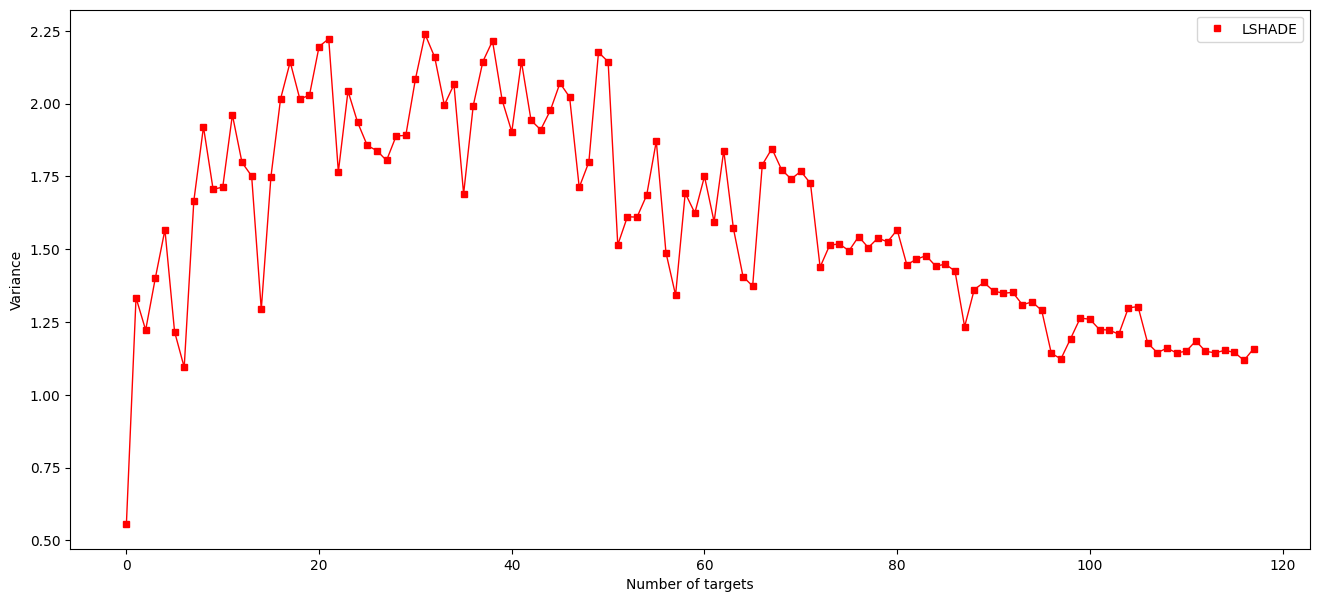

In [ ]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(VAR_fs_avg_lshade))
plt.plot(x_axis, VAR_fs_avg_lshade, 'r-', linewidth=1.0)
plt.plot(x_axis, VAR_fs_avg_lshade, 'rs', markersize=4.5, label='LSHADE')
plt.xlabel("Number of targets")
plt.ylabel("Variance")
plt.legend()
plt.show()

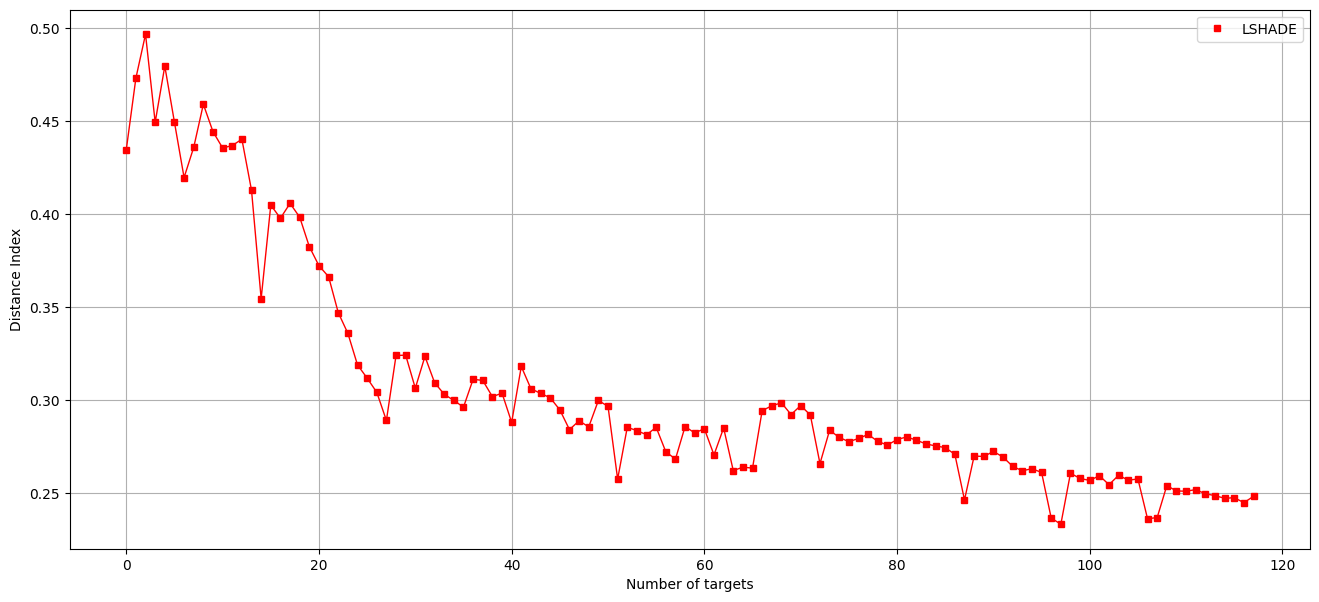

In [ ]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(VAR_fs_avg_lshade))
plt.plot(x_axis, DI_fs_avg_lshade, 'r-', linewidth=1.0)
plt.plot(x_axis, DI_fs_avg_lshade, 'rs', markersize=4.5, label='LSHADE')
plt.xlabel("Number of targets")
plt.ylabel("Distance Index")
plt.legend()
plt.grid()
plt.show()

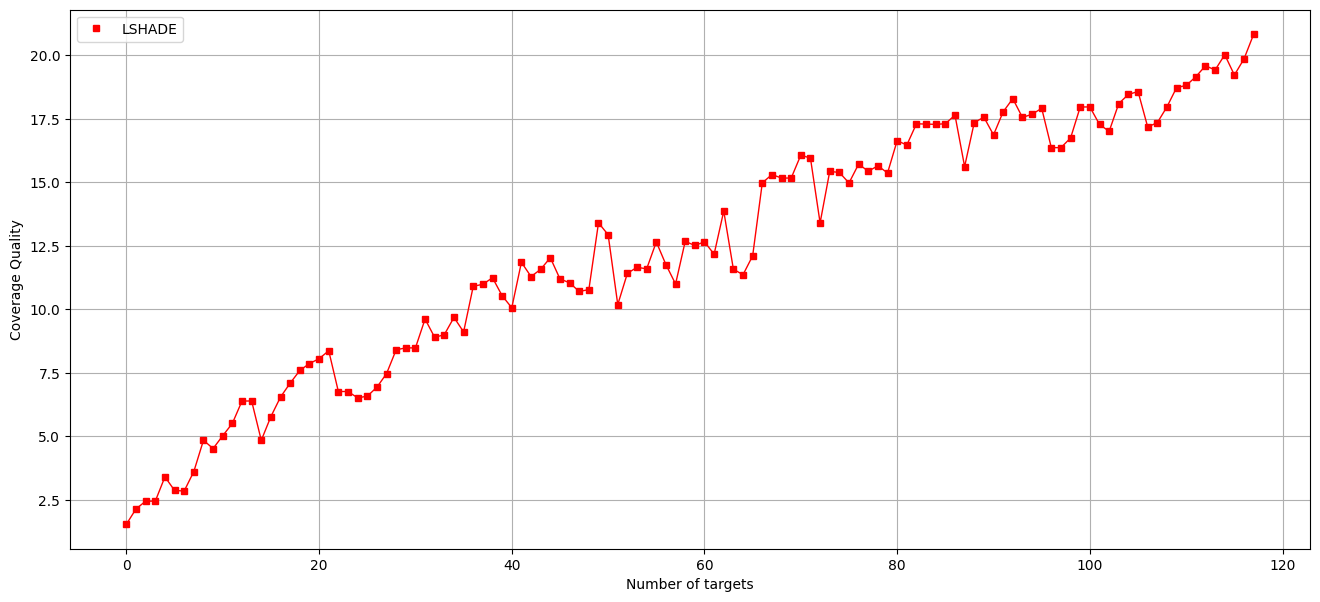

In [ ]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(VAR_fs_avg_lshade))
plt.plot(x_axis, CQ_fs_avg_lshade, 'r-', linewidth=1.0)
plt.plot(x_axis, CQ_fs_avg_lshade, 'rs', markersize=4.5, label='LSHADE')
plt.xlabel("Number of targets")
plt.ylabel("Coverage Quality")
plt.legend()
plt.grid()
plt.show()